In [1]:
import cell2fate as c2f
import scanpy as sc
import numpy as np

Global seed set to 0


In [2]:
savings_directory = '/nfs/team283/aa16/data/cell2fate/trained_models/'

# Parameter settings for this run:
max_epochs = 2000
learning_rate = 0.01
batch_size = None
posterior_samples = 5

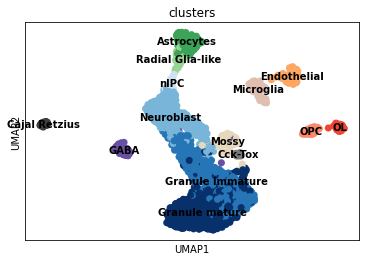

In [3]:
adata = sc.read_h5ad('/nfs/team283/aa16/data/fate_benchmarking/benchmarking_datasets/DentateGyrus/DentateGyrus_anndata.h5ad')
# adata = sc.read_h5ad('/nfs/team283/aa16/data/cell2fate/DentateGyrus_splicedOnly_anndata_with_NMF_GammaWeights_NOdetectionProbability_lr0001_epochs100000_10factors_SingleLineageFiltered_3000genes.h5ad')
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data')

In [4]:
# cluster_column = 'clusters'
# remove_clusters = ['Astrocytes', 'Mossy', 'Cck-Tox', 'OPC', 'OL', 'Radial Glia-like',
#                                                        'Microglia', 'Endothelial', 'GABA', 'Cajal Retzius']
# adata = adata[[c not in remove_clusters for c in adata.obs[cluster_column]], :]

We register the anndata object and create the model instance as with other scvi-tools methods.

In [5]:
# Calculate an initial time based on steady state model:
import scipy
import scvelo as scv
import contextlib
import io

def get_initial_values(adata, origin_clusters = None, velocity_genes = True):
    with contextlib.redirect_stdout(io.StringIO()):
        adata_preprocessed = adata.copy()
        scv.pp.filter_and_normalize(adata_preprocessed)
        scv.pp.moments(adata_preprocessed)
        scv.tl.velocity(adata_preprocessed, mode='steady_state')
        if scipy.sparse.issparse(adata.layers['spliced']):
            adata_preprocessed.layers['spliced'] = np.array(adata_preprocessed.layers['spliced'].toarray(), dtype=np.float32)
        if scipy.sparse.issparse(adata.layers['unspliced']):
            adata_preprocessed.layers['unspliced'] = np.array(adata_preprocessed.layers['unspliced'].toarray(), dtype=np.float32)
        if velocity_genes:
            subset = adata_preprocessed.var['velocity_genes']
        else:
            subset = np.ones(len(adata_preprocessed.var['velocity_genes'])) == 1
        gamma = np.array(adata_preprocessed.var['velocity_gamma'][subset])
        u_counts = np.array(adata_preprocessed.layers['unspliced'][:,subset])
        s_counts = np.array(adata_preprocessed.layers['spliced'][:,subset])
        beta = 1.
        state = ((u_counts - s_counts*np.expand_dims(gamma, axis = 0)) > 0)*1
        n1 = int(adata_preprocessed.n_obs*0.05)
        n2 = adata_preprocessed.n_obs - n1
        u_min = np.mean(np.sort(u_counts, axis = 0)[:n1,:], axis = 0)
        u_max = np.mean(np.sort(u_counts, axis = 0)[n2:,:], axis = 0)
        s_min = np.mean(np.sort(s_counts, axis = 0)[:n1,:], axis = 0)
        s_max = np.mean(np.sort(s_counts, axis = 0)[n2:,:], axis = 0)
        s_inf = np.stack([s_min, s_max], axis = -1)
        u_inf = np.stack([u_min, u_max], axis = -1)
        s_inf = np.array([s_inf[np.arange(np.sum(subset)),state[c,:]] for c in range(adata_preprocessed.n_obs)])
        u_inf = np.array([u_inf[np.arange(np.sum(subset)),state[c,:]] for c in range(adata_preprocessed.n_obs)])
        beta_tilde = np.expand_dims(1/(gamma-1), axis = 0)
        s_tilde =  s_counts - beta_tilde*u_counts
        s_tilde_inf = s_inf - beta_tilde*u_inf + 10**(-5)
        tau_1 = -1/np.expand_dims(gamma, axis = 0)*np.log((s_tilde - s_tilde_inf)/(-s_tilde_inf))
        tau_1[np.isinf(tau_1)] = np.nanmean(np.nanmax(tau_1[~np.isinf(tau_1)], axis = 0))
        upper_limit = np.nanmean(tau_1) + 3*np.sqrt(np.var(tau_1[~np.isnan(tau_1)]))
        lower_limit = np.nanmean(tau_1) - 3*np.sqrt(np.var(tau_1[~np.isnan(tau_1)]))
        tau_1[tau_1 > upper_limit] = upper_limit
        tau_1[tau_1 < lower_limit] = lower_limit
        T_c_initial = np.nanmean(tau_1, axis = -1)
        T_c_initial = T_c_initial - np.min(T_c_initial)
        T_c_initial = T_c_initial/np.max(T_c_initial)/2+0.25
        adata.obs['Initial Time'] = T_c_initial.flatten()
        subset = [g in adata.var_names for g in adata_preprocessed.var_names]
        adata.var['Initial Gamma'] = adata_preprocessed.var['velocity_gamma']
        del adata_preprocessed
        return adata

Get inital values for model parameters:

Keeping at most 100000 cells per cluster
Filtered out 9776 genes that are detected 10 counts (shared).
Extracted 2000 highly variable genes.


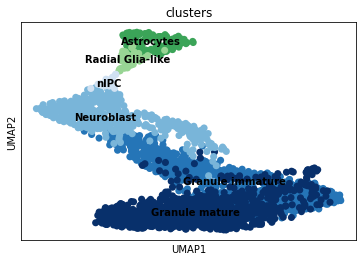

In [6]:
remove_clusters = ['Mossy', 'Cck-Tox', 'OPC', 'OL',
                   'Microglia', 'Endothelial', 'GABA', 'Cajal Retzius']
adata = c2f.utils.get_training_data(adata, cells_per_cluster = 10**5, cluster_column = 'clusters',
                                    remove_clusters = remove_clusters,
                                min_shared_counts = 10, n_var_genes= 2000)
sc.pl.umap(adata, color = ['clusters'], s = 200, legend_loc='on data')

In [7]:
# adata = get_initial_values(adata, origin_clusters = None, velocity_genes = True)

In [8]:
# sc.pl.umap(adata, color = ['Initial Time'], legend_loc = 'right margin',
#                 size = 200, color_map = 'inferno', ncols = 2)

Initialize the model:

In [9]:
n_modules = 6
# init_vals = {}
# init_vals['t_c'] = np.expand_dims(np.expand_dims(adata.obs['Initial Time'], axis = -1), axis = -1)
# init_vals['t_mON'] = np.expand_dims(np.expand_dims(0.33*np.ones(n_modules), axis = 0), axis = 0)
# init_vals['gamma_g'] = np.expand_dims(np.array(adata.var['Initial Gamma']), axis = 0)

In [10]:
c2f.Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime.setup_anndata(adata,
                                                                                    spliced_label='spliced',
                                                                                    unspliced_label='unspliced')

In [11]:
mod = c2f.Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime(adata,
                                                        stochastic_v_ag_hyp_prior={"alpha": 3.0, "beta": 3.0},
                                                        detection_hyp_prior={"alpha": 10.0, "mean_alpha": 1.0, "mean_beta": 1.0},
                                                        Tmax_prior={"mean": 50, "sd": 50},
                                                       n_modules = n_modules)
#                                                        init_vals = init_vals)

In [12]:
mod.view_anndata_setup()

Anndata setup with scvi-tools version 0.16.1.

Setup via `Cell2fate_ModularTranscriptionRate_model_SingleLineage_GlobalTime.setup_anndata` 
with arguments:

{
│   'layer': None,
│   'batch_key': None,
│   'labels_key': None,
│   'unspliced_label': 'unspliced',
│   'spliced_label': 'spliced',
│   'cluster_label': None
}

     Summary Statistics     
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Summary Stat Key ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│     n_cells      │ 2462  │
│      n_vars      │ 2000  │
│     n_batch      │   1   │
└──────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  unspliced   │ adata.layers['unspliced'] │
│   spliced    │  adata.layers['spliced']  │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
└──────────────┴───────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_batch'] │     0      │          0          │
└──────────────────────────┴────────────┴─────────────────────┘

The lower the learning rate and the higher the number of iterations, the better the results. For example a learning rate of 0.001 and 100000 iterations will give slightly better results than here and a learning rate 0.1 and just 100 iterations will give slightly worse results, but has the upside of a very short training time.

In [13]:
mod.train(use_gpu=True, batch_size = batch_size, max_epochs = max_epochs, lr = learning_rate)
# mod.train(use_gpu=True, batch_size = batch_size, max_epochs = 1, lr = 10**(-10)) # (For checking initial values)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 2000/2000: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [07:01<00:00,  4.74it/s, v_num=1, elbo_train=3.53e+6]


We plot training history over multiple windows to effectively assess convergence (which is not reached here but it is close.)

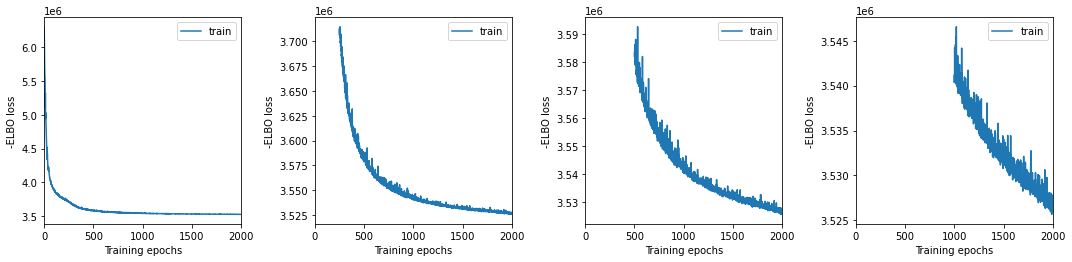

In [14]:
mod.max_epochs = max_epochs
mod.view_history()

Here we export the model posterior to the anndata object and calculate some useful quantities like RNAvelocity based on it.

In [15]:
adata = mod.export_posterior(adata,
                 sample_kwargs = {"num_samples": posterior_samples, "batch_size" : adata.n_obs,
                                  "use_gpu" : True, 'return_samples': True},
                 full_velocity_posterior = True)

Sampling global variables, sample: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.34it/s]


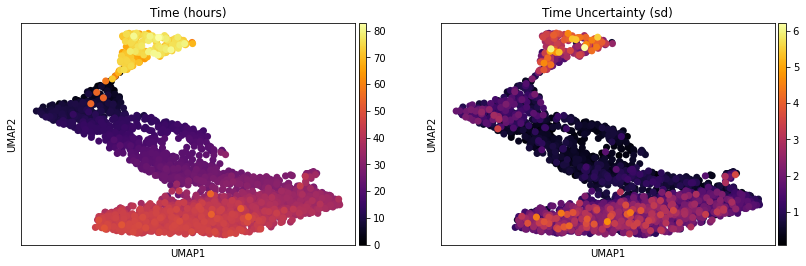

In [17]:
sc.pl.umap(adata, color = ['Time (hours)', 'Time Uncertainty (sd)'], legend_loc = 'right margin',
                size = 200, color_map = 'inferno', ncols = 2)

T_mON [[[ 0.       14.371083 22.069118 31.54866  54.105732 58.112816]]]
T_mOFF [[[ 15.764745  22.99418   31.976166  53.83953   56.01886  100.916916]]]
Tmax 35.811947


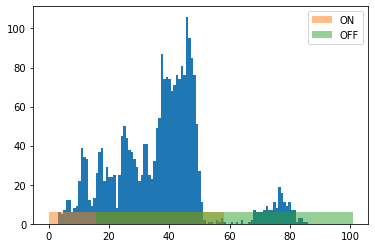

In [18]:
import matplotlib.pyplot as plt
plt.hist(mod.samples['post_sample_means']['T_c'].flatten(), bins = 100)
plt.hist(mod.samples['post_sample_means']['T_mON'].flatten(), bins = 1, alpha = 0.5, label = 'ON')
plt.hist(mod.samples['post_sample_means']['T_mOFF'].flatten(), bins = 1, alpha = 0.5, label = 'OFF')
plt.legend()
print('T_mON', mod.samples['post_sample_means']['T_mON'])
print('T_mOFF', mod.samples['post_sample_means']['T_mOFF'])
print('Tmax', mod.samples['post_sample_means']['Tmax'])

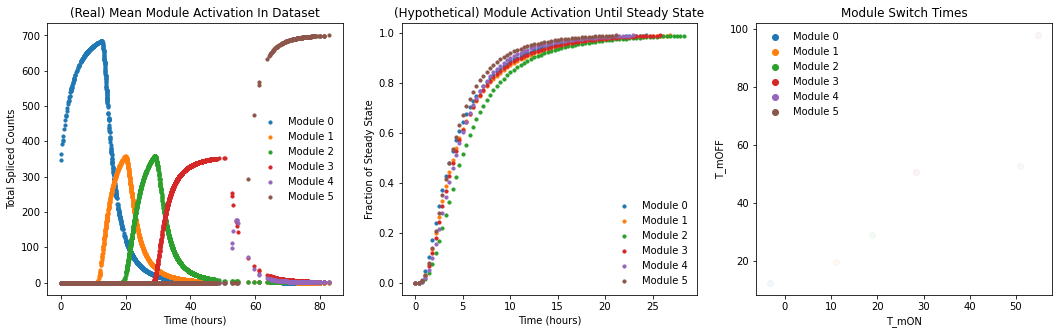

In [19]:
mod.compare_module_activation(adata, chosen_modules = [range(n_modules)], max_time_steps = 200, interval = 0.01)

In [ ]:
# adata.obs['spliced_log10_total'] = np.log10(np.sum(adata.layers['spliced'], axis = 1))
# adata.obs['unspliced_log10_total'] = np.log10(np.sum(adata.layers['unspliced'], axis = 1))
# adata.obs['spliced_total'] = np.sum(adata.layers['spliced'], axis = 1)
# adata.obs['unspliced_total'] = np.sum(adata.layers['unspliced'], axis = 1)
# adata.obs['unspliced_spliced_ratio'] = np.sum(adata.layers['unspliced'], axis = 1)/np.sum(adata.layers['spliced'], axis = 1)
# sc.pl.umap(adata, color = ['spliced_log10_total', 'unspliced_log10_total',
#                            'spliced_total', 'unspliced_total',
#                            'unspliced_spliced_ratio'],
#            legend_loc = 'right margin', size = 200, color_map = 'inferno', ncols = 2)

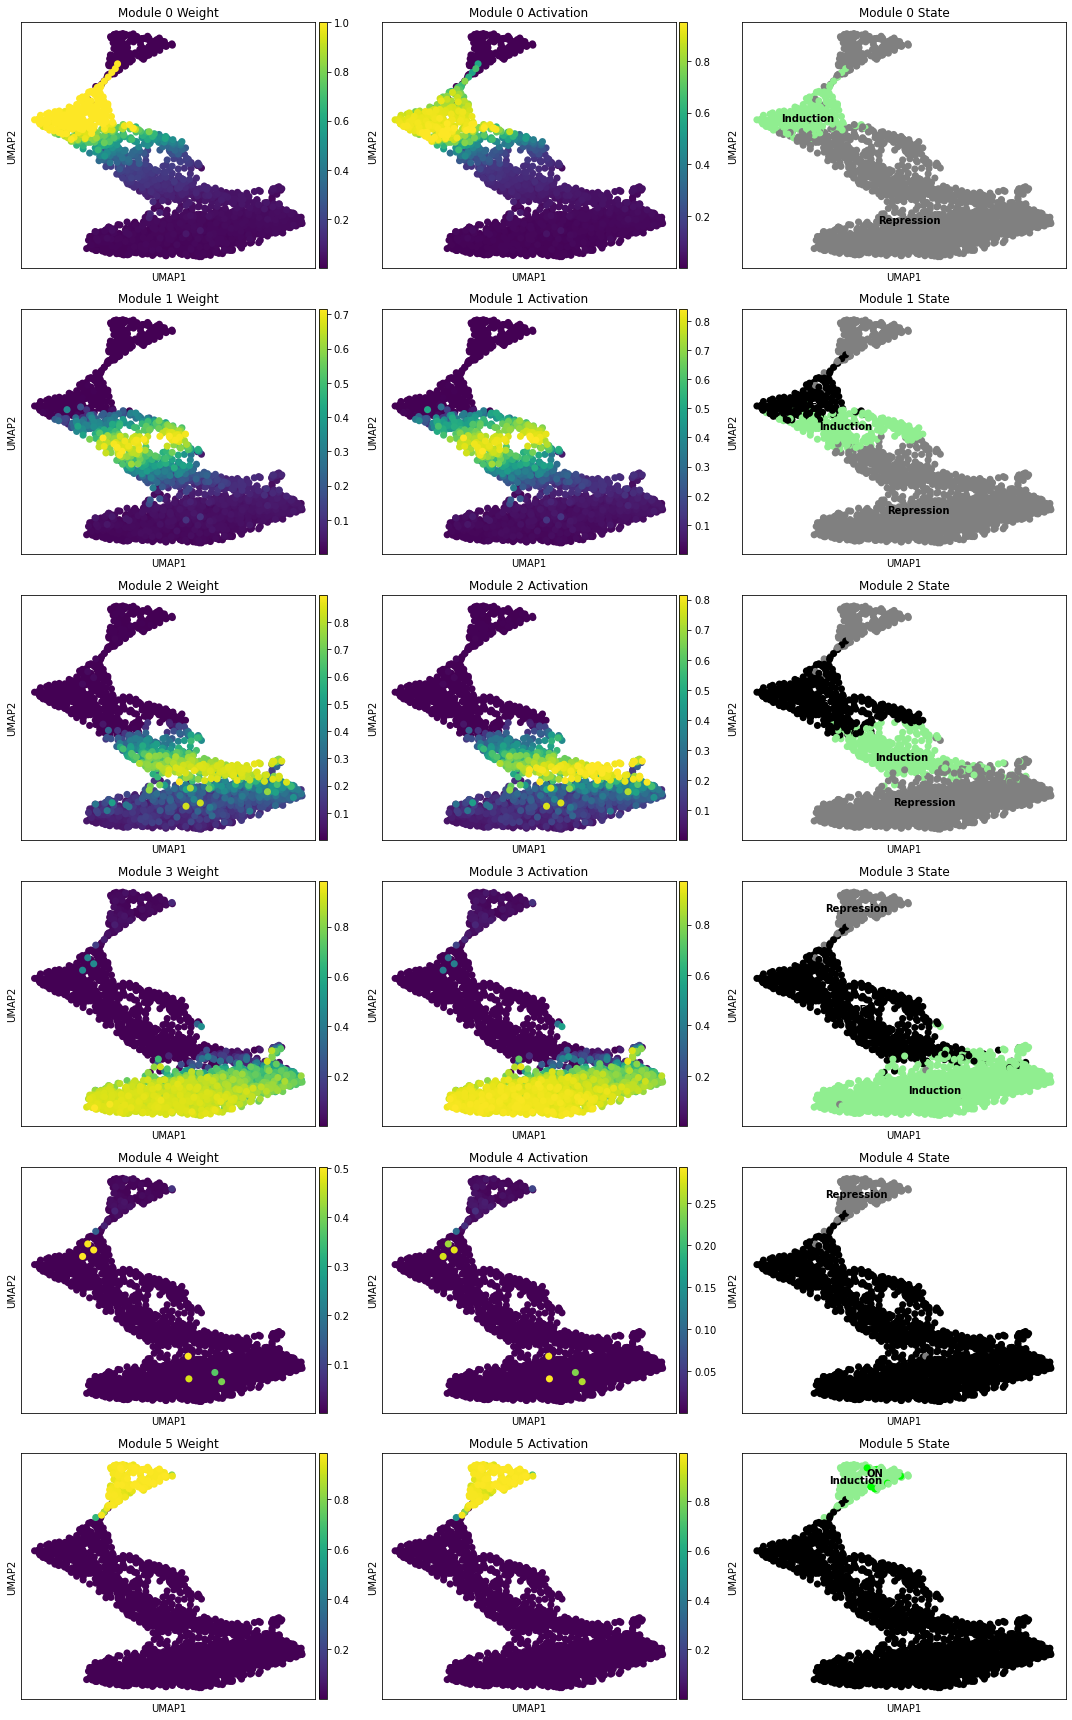

In [20]:
adata = mod.compute_module_summary_statistics(adata)
mod.plot_module_summary_statistics(adata)

In [ ]:
# for i in range(n_modules):
#     adata.obs['Module Weight']

(array([1848.,  159.,   51.,   37.,   27.,   22.,   35.,   33.,   54.,
         196.]),
 array([4.1213693e-04, 9.5265456e-02, 1.9011877e-01, 2.8497210e-01,
        3.7982541e-01, 4.7467875e-01, 5.6953204e-01, 6.6438538e-01,
        7.5923872e-01, 8.5409200e-01, 9.4894534e-01], dtype=float32),
 <BarContainer object of 10 artists>)

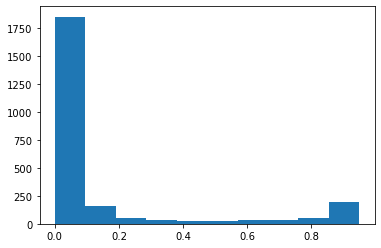

In [21]:
plt.hist(adata.obs['Module 0 Activation'])

Computing velocity produced by Module 0 ...
computing neighbors
    finished (0:00:11) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity embedding
    finished (0:00:00) --> added
    'Module 0 Velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity produced by Module 1 ...
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity embedding
    finished (0:00:00) --> added
    'Module 1 Velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity produced by Module 2 ...
computing neighbors
    finished (0:00:01) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing velocity embedding
    finished (0:00:00) --> added
    'Module 2 Velocity_umap', embedded velocity vectors (adata.obsm)
Computing velocity produced by Module 3 ...
computing neighbors
    finished

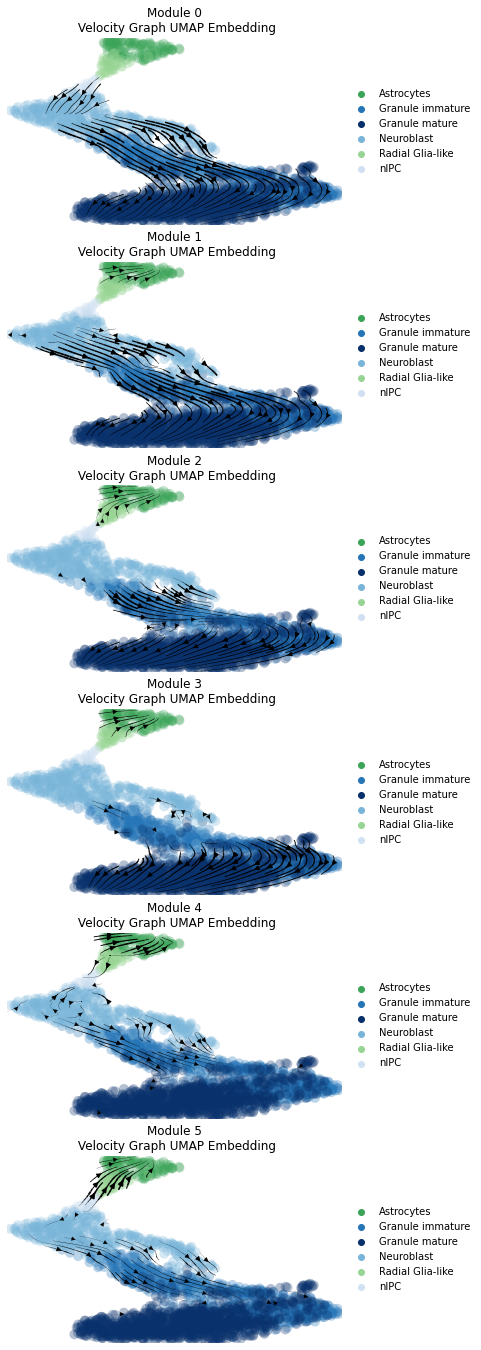

In [22]:
mod.compute_and_plot_module_velocity(adata)

Computing total RNAvelocity ...


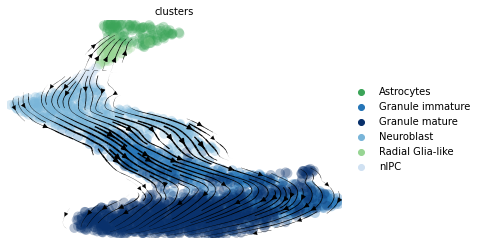

In [23]:
mod.compute_and_plot_total_velocity(adata)

(array([ 862., 1161.,  278.,   83.,   43.,   14.,    9.,    5.,    4.,
           3.]),
 array([ 244. ,  650.9, 1057.8, 1464.7, 1871.6, 2278.5, 2685.4, 3092.3,
        3499.2, 3906.1, 4313. ], dtype=float32),
 <BarContainer object of 10 artists>)

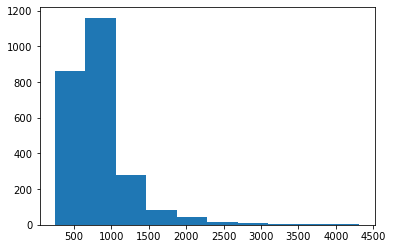

In [24]:
import matplotlib.pyplot as plt
plt.hist(np.sum(adata.layers['spliced'], axis = 1))

(array([126., 254., 320., 320., 734., 529.,  10.,  19.,  96.,  54.]),
 array([ 0.      ,  8.281457, 16.562914, 24.84437 , 33.125828, 41.407284,
        49.68874 , 57.970196, 66.251656, 74.53311 , 82.81457 ],
       dtype=float32),
 <BarContainer object of 10 artists>)

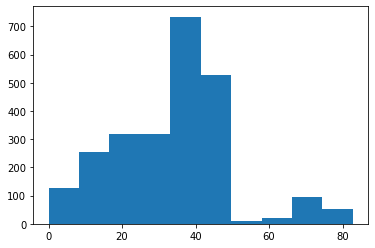

In [25]:
plt.hist(mod.samples['post_sample_means']['T_c'].flatten() - np.min(mod.samples['post_sample_means']['T_c'].flatten()))

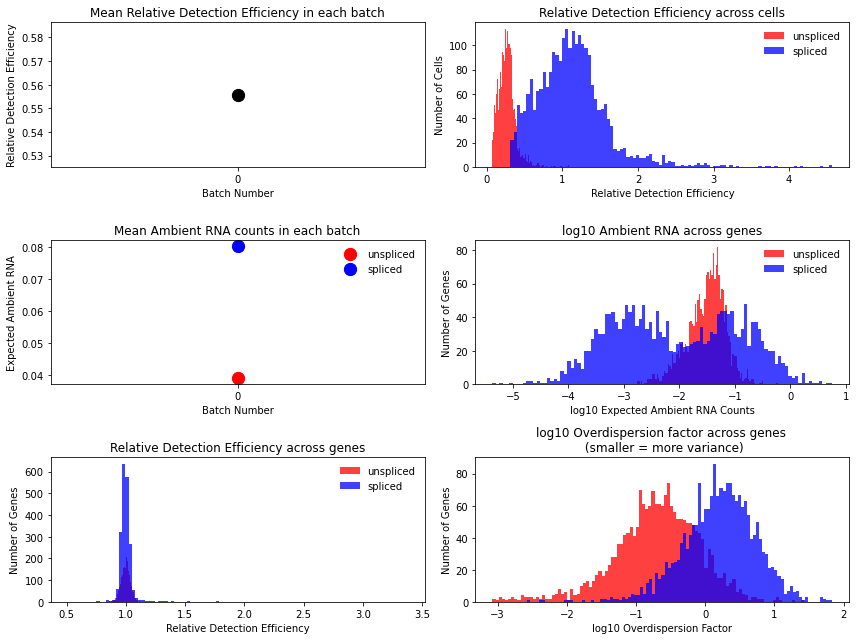

In [26]:
mod.plot_technical_variables(adata)

In [27]:
print('A_mgON mean:', np.mean(mod.samples['post_sample_means']['A_mgON']))
print('gamma_g mean:', np.mean(mod.samples['post_sample_means']['gamma_g']))
print('beta_g mean:', np.mean(mod.samples['post_sample_means']['beta_g']))
print('lam_mi, all modules: \n \n', np.round(mod.samples['post_sample_means']['lam_mi'],2))

A_mgON mean: 0.15396976
gamma_g mean: 0.82689714
beta_g mean: 1.0167756
lam_mi, all modules: 
 
 [[[3.35 2.89]]

 [[1.95 3.06]]

 [[0.73 1.82]]

 [[1.46 2.09]]

 [[0.89 1.14]]

 [[1.16 1.54]]]


In [28]:
tab = mod.get_module_top_features(adata, p_adj_cutoff=0.1)
tab

,Module Number,Genes Ranked,TFs Ranked,Terms Ranked
0,0,"Gal, Calb2, Pafah1b3, Podxl2, Flrt1, Rbm17, Bc...","Yeats4, Rcor2, E2f1, Egr1, Fosb, Ezh2, Nfix, Y...","protein targeting to ER (GO:0045047), SRP-depe..."
1,1,"Gap43, Emc4, Arhgdig, Sec11c, Mkks, Rnf14, Uqc...","Pknox1, Mllt11, Ybx1, Lrrfip1, Klf7, Fos, Fosb...","neuron projection development (GO:0031175), re..."
2,2,"Moxd1, Dnajc14, Fndc1, Ptprj, Hs3st4, Parp1, L...","Parp1, Zmat4, Nr3c2, Snapc4, Pknox1, Mkx, Klf9...",regulation of neuronal synaptic plasticity (GO...
3,3,"Grasp, Arsj, Fst, Spi1, Wbp11, Ccdc12, Adarb2,...","Kdm5d, Tshz3, Sox8, Rcor3, Mynn, Grhl1, Zc3h13...",
4,4,"Sdcbp, Fxr1, Gm15965, Ankrd26, Scpep1, Tcp11, ...","Zfp558, Erg, Ctcf, Dnajc1, Foxj2, Prdm10, Zbtb...","sperm flagellum (GO:0036126), 9+2 motile ciliu..."
5,5,"Abhd3, Gja1, Scrg1, Nacc2, Hapln1, Gfap, Slc9a...","Id3, Nr2e1, Npas3, Dbx2, Sox6, Rorb, Eno1, Id2...","acidic amino acid transport (GO:0015800), vasc..."


In [33]:
tab['Terms Ranked'].iloc[2]

'regulation of neuronal synaptic plasticity (GO:0048168), chemical synaptic transmission (GO:0007268), regulation of cation channel activity (GO:2001257), synaptic transmission, glutamatergic (GO:0035249), cardiac muscle cell membrane repolarization (GO:0099622), regulation of calcium ion transport (GO:0051924), regulation of neurotransmitter receptor activity (GO:0099601), regulation of NMDA receptor activity (GO:2000310), regulation of short-term neuronal synaptic plasticity (GO:0048172), membrane repolarization during action potential (GO:0086011), membrane repolarization during cardiac muscle cell action potential (GO:0086013), membrane repolarization (GO:0086009), modulation of chemical synaptic transmission (GO:0050804), heterophilic cell-cell adhesion via plasma membrane cell adhesion molecules (GO:0007157), regulation of ion transport (GO:0043269), synapse organization (GO:0050808), anterograde trans-synaptic signaling (GO:0098916), maintenance of synapse structure (GO:0099558)

calculating cell cycle phase
-->     'S_score' and 'G2M_score', scores of cell cycle phases (adata.obs)


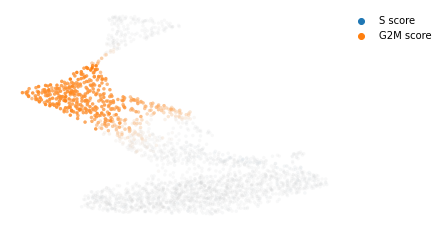

In [29]:
import scvelo as scv
scv.tl.score_genes_cell_cycle(adata)
scv.pl.scatter(adata, color_gradients=['S_score', 'G2M_score'], smooth=True, perc=[5, 95])

This is how we can save the model and anndata object for later use:

In [ ]:
save = False
if save:
    # Make an interpretable name for this run:
    run_name = savings_directory + 'PancreasData' + '+Genes_' + str(len(adata.var_names)) + \
    '+Cells_' + str(len(adata.obs_names)) +  \
    '+Model_Cell2fate_ModularTranscriptionRate_NoSplicing_2' + '+Modules_' + str(max_modules) \
    + '+Lineages_' + str(max_lineages) + '+TrainingEpochs_' + str(max_epochs) \
    + '+LearningRate_' + str(learning_rate) + '+BatchSize_' + str(batch_size) + '+PosteriorSamples_' + str(posterior_samples)
    adata_file = run_name + "/anndata.h5ad"
    # Save model:
    mod.save(f"{run_name}", overwrite=True)
    # Save adata object:
    adata.write(adata_file)

This is how we can load the model again:

In [ ]:
# adata = sc.read_h5ad(adata_file)
# mod = c2f.Cell2fate_ModularTranscriptionRate_FixedModules.load(f"{run_name}", adata)